In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Modules

In [1]:
! pip install bs4 lxml kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=60b26811cc278c1d9bae2b6e01c0240f908d8f81bb5e063ee3ae18cf2feab748
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [5]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.3 MB/s eta 0:00:00


# Download Dataset from Kaggle

In [6]:
import os
os.environ['KAGGLE_USERNAME'] = 'bilalyousaf0014'
os.environ['KAGGLE_KEY'] = '11031bc21c5e3ec23585dbe17dc4267d'

In [7]:
!kaggle datasets download -d bilalyousaf0014/ml-engineer-assessment-dataset

100% 78.6M/78.6M [00:03<00:00, 31.3MB/s]
100% 78.6M/78.6M [00:03<00:00, 22.9MB/s]


In [8]:
! unzip /content/ml-engineer-assessment-dataset.zip

Archive:  /content/ml-engineer-assessment-dataset.zip
  inflating: assessment_dataset/images/00001.jpeg  
  inflating: assessment_dataset/images/00008.jpeg  
  inflating: assessment_dataset/images/00017.jpeg  
  inflating: assessment_dataset/images/00022.jpeg  
  inflating: assessment_dataset/images/00048.jpeg  
  inflating: assessment_dataset/images/00055.jpeg  
  inflating: assessment_dataset/images/001.jpeg  
  inflating: assessment_dataset/images/1.jpeg  
  inflating: assessment_dataset/images/1001524.jpeg  
  inflating: assessment_dataset/images/1005343.jpeg  
  inflating: assessment_dataset/images/1049854.jpeg  
  inflating: assessment_dataset/images/1072860.jpeg  
  inflating: assessment_dataset/images/1120419.jpeg  
  inflating: assessment_dataset/images/1146885.jpeg  
  inflating: assessment_dataset/images/2.jpeg  
  inflating: assessment_dataset/images/3.jpeg  
  inflating: assessment_dataset/images/4.jpeg  
  inflating: assessment_dataset/images/5.jpeg  
  inflating: assessm

# Importing Required Libraries

In [65]:
import os
import torch
import torch.nn as nn
import numpy as np

from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
import torchmetrics
from bs4 import BeautifulSoup


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb
from PIL import ImageDraw
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.init as init



# ENCODING ANIMAL AND SPECIES CLASS (GLOBAL_VARIABLE)
This section will encode the different species and animal categories that will be used to get the actual names of the species and animals after prediction. An additional class NA is added for the species and animals that do not exist

In [48]:
SPECIES = ['Abyssinian', 'Birman', 'Persian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'chihuahua', 'pomeranian', 'NA']
SPECIES_TO_INDEX = {specie: index for index, specie in enumerate(SPECIES)}



CAT_OR_DOG = ['cat', 'dog', 'NA']
CAT_OR_DOG_TO_INDEX = {cat_or_dog: index for index, cat_or_dog in enumerate(CAT_OR_DOG)}
CAT_OR_DOG_TO_INDEX, SPECIES_TO_INDEX

({'cat': 0, 'dog': 1, 'NA': 2},
 {'Abyssinian': 0,
  'Birman': 1,
  'Persian': 2,
  'american_bulldog': 3,
  'american_pit_bull_terrier': 4,
  'basset_hound': 5,
  'beagle': 6,
  'chihuahua': 7,
  'pomeranian': 8,
  'NA': 9})

# CUSTOM DATALOADER IMPLEMENTATION

In [10]:

train_list = np.load('/content/assessment_dataset/train_list.npy', allow_pickle=True).tolist()
val_list = np.load('/content/assessment_dataset/val_list.npy', allow_pickle=True).tolist()

In [11]:
len(train_list)

832

In [276]:
len(val_list)

208

In [49]:


def read_xml_file(path):
    """
    Read an XML file and extract relevant information.

    Args:
        path (str): Path to the XML file.

    Returns:
        dict: A dictionary containing the extracted information.
            - 'has_object' (bool): Indicates whether the XML file has an object.
            - 'cat_or_dog' (str): Specifies the category of the object (cat or dog).
            - 'xmin' (int): The x-coordinate of the top-left corner of the bounding box.
            - 'ymin' (int): The y-coordinate of the top-left corner of the bounding box.
            - 'xmax' (int): The x-coordinate of the bottom-right corner of the bounding box.
            - 'ymax' (int): The y-coordinate of the bottom-right corner of the bounding box.
            - 'specie' (str): The species specified in the XML file, extracted from the file path.

    Raises:
        FileNotFoundError: If the XML file at the specified path does not exist.

    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    with open(path, 'r') as f:
        data = f.read()

    bs_data = BeautifulSoup(data, 'xml')

    return {
        "has_object": True,
        "cat_or_dog": bs_data.find("name").text,
        "xmin": int(bs_data.find("xmin").text),
        "ymin": int(bs_data.find("ymin").text),
        "xmax": int(bs_data.find("xmax").text),
        "ymax": int(bs_data.find("ymax").text),
        "specie": "_".join(path.split(os.sep)[-1].split("_")[:-1])
    }


## Visualizing the images

In [50]:
# test the bounding boxes
test_xml = read_xml_file('/content/assessment_dataset/labels/pomeranian_117.xml')

In [51]:
test_xml

{'has_object': True,
 'cat_or_dog': 'dog',
 'xmin': 140,
 'ymin': 4,
 'xmax': 236,
 'ymax': 128,
 'specie': 'pomeranian'}

In [57]:
def visualize_test_images(image_name: str, image_folder_path: str):
    """
    Visualize the test image with the bounding box and object information.

    Args:
        image_name (str): The name of the test image (without file extension).
        image_folder_path (str): The path to the folder containing the test image.

    Returns:
        None

    """
    image_path = os.path.join(image_folder_path, image_name + ".jpg")
    image = Image.open(image_path)

    # Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

    bbox = [test_xml['xmin'], test_xml['ymin'], test_xml['xmax'], test_xml['ymax']]

    have_object = test_xml['has_object']
    cat_or_dog = test_xml['cat_or_dog']
    species_name = test_xml['specie']

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    if have_object:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        plt.text(10, 10, 'Specie: {} Cat or Dog: {}'.format(species_name, cat_or_dog), color='white',
                 bbox=dict(facecolor='red', alpha=0.5))

    return


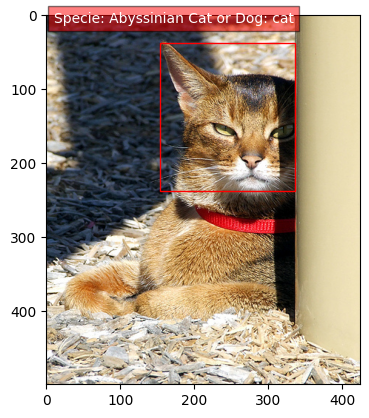

In [64]:
test_xml = read_xml_file('/content/assessment_dataset/labels/Abyssinian_152.xml')
image_name = 'Abyssinian_152'
image_folder_path = '/content/assessment_dataset/images/'
visualize_test_images(image_name, image_folder_path)

# Custom Dataset

In [282]:
class CustomDataset():
    """
    Custom dataset class for image classification and object detection.

    Args:
        dataset_path (str): The path to the dataset directory.
        images_list (list): A list of image names.
        train (bool, optional): Specifies whether the dataset is used for training or not. Default is False.

    Attributes:
        train (bool): Specifies whether the dataset is used for training or not.
        dataset_path (str): The path to the dataset directory.
        images_list (list): A list of image names.
        image_folder_path (str): The path to the folder containing the images.
        label_folder_path (str): The path to the folder containing the labels.
        preprocess (torchvision.transforms.Compose): Preprocessing transformations to apply to the images.
        data (list): A list of tuples containing the image path and label data.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(index): Retrieves a specific image and its corresponding labels from the dataset.

    """

    def __init__(self, dataset_path, images_list, train=False):
        self.train = train
        self.dataset_path = dataset_path
        self.images_list = images_list
        self.image_folder_path = os.path.join(dataset_path, "images")
        self.label_folder_path = os.path.join(dataset_path, "labels")

        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.data = []
        for path in os.listdir(self.image_folder_path):
            name = path.split(os.sep)[-1].split(".")[0]
            if name in images_list:
                image_path = os.path.join(self.image_folder_path, path)
                xml_path = os.path.join(self.label_folder_path, name + ".xml")
                xml_data = read_xml_file(xml_path) if os.path.isfile(xml_path) else self.default_xml_data()
                self.data.append((image_path, xml_data))

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.

        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Retrieves a specific image and its corresponding labels from the dataset.

        Args:
            index (int): The index of the image to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding labels.

        """
        image_path, labels = self.data[index]
        image = Image.open(image_path)
        if self.preprocess is not None:
            image = self.preprocess(image)

        bbox = torch.tensor([labels["xmin"], labels["ymin"], labels["xmax"], labels["ymax"]])
        has_object = torch.tensor(1 if labels["has_object"] else 0, dtype=torch.float32)
        cat_or_dog = torch.tensor(CAT_OR_DOG_TO_INDEX[labels["cat_or_dog"]], dtype=torch.long)
        specie = torch.tensor(SPECIES_TO_INDEX[labels["specie"]], dtype=torch.long)

        # Return as a dictionary
        labels = {"bbox": bbox, "has_object": has_object, "cat_or_dog": cat_or_dog, "specie": specie}
        return image, labels

    def default_xml_data(self):
        """
        Returns a default dictionary in case there is no object in the image.

        Returns:
            dict: The default label data dictionary.

        """
        return {
            "has_object": False,
            "cat_or_dog": "NA",
            "specie": "NA",
            "xmin": 0,
            "ymin": 0,
            "xmax": 0,
            "ymax": 0
        }


# MODEL IMPLEMENTATION:

In [66]:
class Model(nn.Module):
    """
    Model class for the neural network.

    Attributes:
        backbone (nn.Sequential): The backbone architecture of the model.
        avg_pool (nn.AdaptiveAvgPool2d): Adaptive average pooling layer.
        dropout (nn.Dropout): Dropout layer for regularization.
        have_object (nn.Linear): Fully connected layer for binary classification (object detection).
        cat_or_dog (nn.Linear): Fully connected layer for multi-class classification (cat or dog).
        specie (nn.Linear): Fully connected layer for multi-class classification (species).
        bbox (nn.Linear): Fully connected layer for bounding box regression.

    Methods:
        forward(input): Performs a forward pass of the input through the model.

    """

    def __init__(self):
        super(Model, self).__init__()
        pretrained_model = resnet18(pretrained=True)
        pretrained_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(pretrained_model.children())[:-2])

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)

        num_features = 2048

        # Fully connected layers for each task
        self.have_object = nn.Linear(num_features, 1)  # binary classification
        self.cat_or_dog = nn.Linear(num_features, 3)  # multi-class classification
        self.specie = nn.Linear(num_features, 10)  # multi-class classification
        self.bbox = nn.Linear(num_features, 4)  # bounding box regression

        # Xavier initialization
        init.xavier_uniform_(self.have_object.weight)
        init.xavier_uniform_(self.cat_or_dog.weight)
        init.xavier_uniform_(self.specie.weight)
        init.xavier_uniform_(self.bbox.weight)

    def forward(self, input):
        """
        Performs a forward pass of the input through the model.

        Args:
            input (torch.Tensor): The input tensor.

        Returns:
            dict: A dictionary containing the outputs of the model.

        """
        out_backbone = self.backbone(input)
        out_backbone = self.avg_pool(out_backbone)
        out_backbone = self.dropout(out_backbone)
        out_backbone = out_backbone.view(out_backbone.size(0), -1)  # Flatten

        have_object = torch.sigmoid(self.have_object(out_backbone))
        cat_or_dog = torch.softmax(self.cat_or_dog(out_backbone), dim=-1)
        specie = torch.sigmoid(self.specie(out_backbone))
        bbox = torch.sigmoid(self.bbox(out_backbone))

        return {
            "bbox": bbox,
            "object": have_object,
            "cat_or_dog": cat_or_dog,
            "specie": specie
        }


In [67]:
model = Model()
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

# TRAINING LOOP IMPLEMENTATION
This section will implement basic initialization of the model parameters and the subsequent training routine for the models

## Initializations

In [14]:
MODEL_PATH = '/content/drive/MyDrive/mtailor/models/'
BATCH_SIZE = 32
training_dataset = CustomDataset("/content/assessment_dataset", images_list=train_list)
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training Loop

In [ ]:
def train(epochs, model_weights=None):
    """
    Trains the model for the specified number of epochs.

    Args:
        epochs (int): The number of epochs to train the model.
        model_weights (str): Path to the model weights file (default: None).

    """
    # Initialize Model and Optimizer
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initialize Loss Functions
    have_object_loss = torch.nn.BCEWithLogitsLoss()
    specie_loss = torch.nn.CrossEntropyLoss()
    cat_or_dog_loss = torch.nn.CrossEntropyLoss()
    bbox_loss = torch.nn.SmoothL1Loss()

    training_dataset = CustomDataset("/content/assessment_dataset", images_list=train_list)
    training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

    if model_weights is not None:
        model.load_state_dict(torch.load(model_weights))

    if torch.cuda.is_available():
        model = model.cuda()

    best_val_metric = float('-inf')  # Variable to track the best validation metric score
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)

    def train_one_epoch(epoch_index):
        """
        Trains the model for one epoch.

        Args:
            epoch_index (int): The index of the current epoch.

        Returns:
            float: The loss value for the last batch of the epoch.

        """
        running_loss = 0.
        last_loss = 0.

        # Set model to training mode
        model.train()

        # Loop over each batch from the training set
        for i, data in enumerate(training_loader):
            # Unpack the inputs from our dataloader
            inputs, labels = data
            inputs = inputs.cuda()

            # Forward pass
            outputs = model(inputs)

            # Zero the gradients
            optimizer.zero_grad()

            # Compute loss
            loss_have_object = have_object_loss(outputs["object"].view(-1), labels["has_object"].cuda())
            loss_have_object = loss_have_object.sum()

            loss_specie = specie_loss(outputs["specie"], labels["specie"].cuda())
            loss_specie = loss_specie.sum()

            loss_cat_or_dog = cat_or_dog_loss(outputs["cat_or_dog"], labels["cat_or_dog"].cuda())
            loss_cat_or_dog = loss_cat_or_dog.sum()

            loss_bbox = bbox_loss(outputs["bbox"], labels["bbox"].cuda())
            loss_bbox = loss_bbox.sum()

            # Consolidate losses
            loss = loss_have_object + loss_specie + loss_cat_or_dog + loss_bbox

            # Check if the result tensor requires gradient
            if loss.requires_grad:
                # Compute gradients and perform backpropagation
                loss.backward()

            # Perform optimization
            optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            if i % 10 == 0:
                last_loss = running_loss / 10  # loss per batch
                running_loss = 0.
        return last_loss

    for i in range(epochs):
        epoch_loss = train_one_epoch(i)
        print(f' Epoch {i} Train Loss : {epoch_loss}')

        metrics = validation(model, val_list)

        val_loss, val_object, val_cat_or_dog, val_specie, val_bbox = metrics

        val_metric = val_object + val_cat_or_dog + val_specie + val_bbox

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            torch.save(model.state_dict(), f"{MODEL_PATH}/best_model.pth")

        scheduler.step(best_val_metric)  # Adjust learning rate based on validation metric

        print(metrics)


def validation(model, val_list):
    """
    Performs validation on the model.

    Args:
        model: The trained model.
        val_list: List of validation images.

    Returns:
        tuple: A tuple containing the validation scores for each metric.

    """
    model.eval()
    running_loss = 0.0
    val_dataset = CustomDataset("/content/assessment_dataset", images_list=val_list)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    # Set model to evaluation mode
    model.eval()
    metric_object = torchmetrics.Accuracy(task='binary').cuda()
    metric_cat_or_dog = torchmetrics.Accuracy(task='multiclass', num_classes=3).cuda()
    metric_specie = torchmetrics.Accuracy(task='multiclass', num_classes=10).cuda()
    metric_bbox = torchmetrics.MeanAbsoluteError().cuda()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs = inputs.cuda()

            outputs = model(inputs)
            metric_object(outputs["object"].view(-1), labels["has_object"].cuda())
            metric_cat_or_dog(outputs["cat_or_dog"], labels["cat_or_dog"].cuda())
            metric_specie(outputs["specie"], labels["specie"].cuda())
            metric_bbox(outputs["bbox"], labels["bbox"].cuda())

    score_object = metric_object.compute()
    score_cat_or_dog = metric_cat_or_dog.compute()
    score_specie = metric_specie.compute()
    score_bbox = metric_bbox.compute()

    return score_object, score_cat_or_dog, score_specie, score_bbox


In [ ]:
NUM_EPOCHS = 200
train(NUM_EPOCHS, model_weights=None)

# Loading Model from the given weight to continue training
To continue retraining the model, load the model weights for the best performing model and then run the following cell to get a better performance of the model. 


In [ ]:
NUM_EPOCHS = 20
train(NUM_EPOCHS, model_weights=f"{MODEL_PATH}/best_model.pth")

# Visualizing Model Outputs

In [30]:
def visualize(model_weights, image_names, image_folder_path, output_folder="output"):
    """
    Visualizes the predictions of the model on the specified images.

    Args:
        model_weights (str): Path to the model weights file.
        image_names (list): List of image names to visualize.
        image_folder_path (str): Path to the folder containing the images.
        output_folder (str): Path to the output folder (default: "output").

    Returns:
        dict: A dictionary containing the visualization results for each image.

    """
    model = Model()
    model.load_state_dict(torch.load(model_weights, map_location=torch.device('cpu')))
    model.eval()
    results = {}

    for image_name in image_names:
        try:
            image = Image.open(os.path.join(image_folder_path, image_name + ".jpg"))
        except:
            image = Image.open(os.path.join(image_folder_path, image_name + ".jpeg"))

        # Preprocessing
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)

        input_batch = input_batch.to('cpu')  # Move input tensor to CPU

        with torch.no_grad():
            output = model(input_batch)

        bbox = output['bbox'].cpu().numpy()
        bbox = bbox.squeeze()  # Remove any extra dimensions
        bbox = bbox.tolist()  # Convert to a list

        have_object = output['object'].item() > 0.5

        cat_or_dog_index = output['cat_or_dog'].argmax(dim=1).item()
        cat_or_dog = next(key for key, value in CAT_OR_DOG_TO_INDEX.items() if value == cat_or_dog_index)

        species_index = output['specie'].argmax(dim=1).item()
        species_name = next(key for key, value in SPECIES_TO_INDEX.items() if value == species_index)

        fig, ax = plt.subplots(1)
        ax.imshow(image)

        image_name_ = image_name + ".jpg"

        values = {
            'has_object': have_object,
            'cat_or_dog': cat_or_dog,
            'specie': species_name,
            'xmin': bbox[0],
            'ymin': bbox[1],
            'xmax': bbox[2],
            'ymax': bbox[3]
        }
       
        results[image_name_] = values

    return results


# Testing Model On Unseen Data
In order to test the model on unseen data:
- First specify the images as a list of image names as in the images variable. 
- Then specify the path to the uploaded model weights in the `model_weights` variable by changing the MODEL_PATH to the appropriate path to the model
- Then specify the path to the image folder where the images are stored
- Also specify the output path for storing the predictions and visualized images in the outputs variable below. 
- The below code can then be run to perform inference on the test dataset on CPU


In [31]:
OUTPUT_PATH = '/content/drive/MyDrive/mtailor/output/'
MODEL_WEIGHTS = f"{MODEL_PATH}/best_model.pth"
image_folder_path = '/content/assessment_dataset/images/'
images = ['pomeranian_117' , 'pomeranian_114']

{'pomeranian_117.jpg': {'has_object': True,
  'cat_or_dog': 'dog',
  'specie': 'Birman',
  'xmin': 0.4703121483325958,
  'ymin': 0.5065815448760986,
  'xmax': 0.5134862661361694,
  'ymax': 0.5505483746528625},
 'pomeranian_114.jpg': {'has_object': False,
  'cat_or_dog': 'cat',
  'specie': 'pomeranian',
  'xmin': 0.49509912729263306,
  'ymin': 0.497806191444397,
  'xmax': 0.5094975829124451,
  'ymax': 0.5157261490821838}}

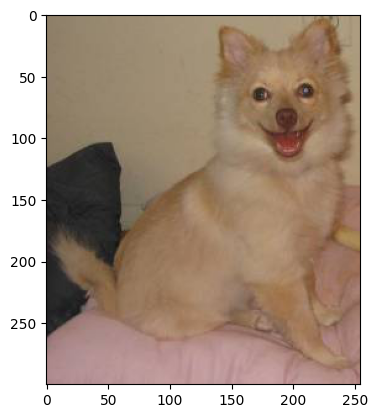

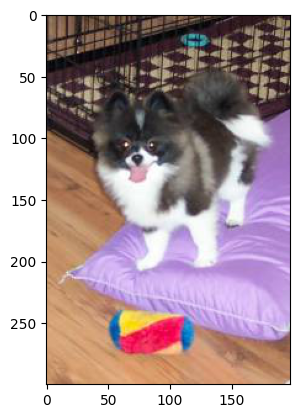

In [33]:
output = visualize(MODEL_WEIGHTS, images, image_folder_path, output_folder=OUTPUT_PATH)
output

In [34]:
output

{'pomeranian_117.jpg': {'has_object': True,
  'cat_or_dog': 'dog',
  'specie': 'Birman',
  'xmin': 0.4703121483325958,
  'ymin': 0.5065815448760986,
  'xmax': 0.5134862661361694,
  'ymax': 0.5505483746528625},
 'pomeranian_114.jpg': {'has_object': False,
  'cat_or_dog': 'cat',
  'specie': 'pomeranian',
  'xmin': 0.49509912729263306,
  'ymin': 0.497806191444397,
  'xmax': 0.5094975829124451,
  'ymax': 0.5157261490821838}}